# Detecting Pneumonia from Chest X-Ray Images

*Pneumonia* is an inflammatory condition of the lung that mainly affects the alveoli. It is usually caused by infection with bacteria or viruses and it is the cause of approximately 7% of global deaths (3 million deaths in 2016) **[1, 2]**. The diagnosis is usually based on physical signs and a chest X-ray image.

Machine Learning (ML) techniques have been used to gain information about pneumonia cases for more than two decades **[3]**. The recent popularization of ML has led to further advances in this field **[4]**.

This notebook demonstrates the ability of a Convolutional Neural Network (CNN) to classify chest X-ray images according to whether the patient has pneumonia or not. The dataset is available on Kaggle **[5]**. Although no prior domain expertise about pneumonia is injected into the CNN the trained model achieves greater than 90% accuracy on the test set. For details, see

**[1]** https://en.wikipedia.org/wiki/Pneumonia (wikipedia page on pneumonia),<br>
**[2]** https://en.wikipedia.org/wiki/Epidemiology_of_pneumonia (wikipedia page on the epidemiology of pneumonia),<br>
**[3]** https://www.sciencedirect.com/science/article/pii/S0933365796003673 (1997 paper on machine learning and pneumonia),<br>
**[4]** https://stanfordmlgroup.github.io/projects/chexnet (CheXNet web page), and<br>
**[5]** https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia (Chest X-Ray dataset on Kaggle).


In [1]:
from sklearn.metrics import confusion_matrix, roc_curve, classification_report
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)
tf.test.is_gpu_available()

/home/matthias/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/matthias/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/matthias/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/matthias/anaconda3/lib/python3.6/site-packages/tensorflow/python/frame

1.12.0


True

The original chest X-ray dataset (path wrt this .ipynb file: `datasets/chest_xray`) on Kaggle has 5216 training, 16 validation, and 624 test instances. After a model has been trained on the training set, the trained model is evaluated on the validation set. Depending on that result, the model architecture and hyperparameters will be modified or the final performance will be assessed on the test set. However, with much fewer instances than the training and test sets, the original validation set cannot serve as a good indicator for the model performance.

Consequently, a modfied dataset (path wrt this .ipynb file: `datasets/chest_xray_mod`) has been created that is identical to the original dataset but for 144 instances (72 *normal* and 72 *pneumonia*) that have been moved from the test set to the validation set.

We establish generators for training, validation, and testing. Several image modifications (rotation, zoom, shift of width, and shift of height) are applied during training to augment the data. The `flow_from_directory()` method automatically infers the class labels from the different folder names in which the different class instances are sorted **[6, 7]**. Additionally, this method allows the specification of the image size. It is chosen such that all convolutions match exactly (but this is not necessary). One instance from the validation set is selected randomly and displayed. For details, see

**[6]** https://keras.io/preprocessing/image/ (Keras documentation on generators and `flow_from_directory`) and<br>
**[7]** https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720 (Medium article outlining the usage on generators and `flow_from_directory` in Keras).

Found 5072 images belonging to 2 classes.
Found 160 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


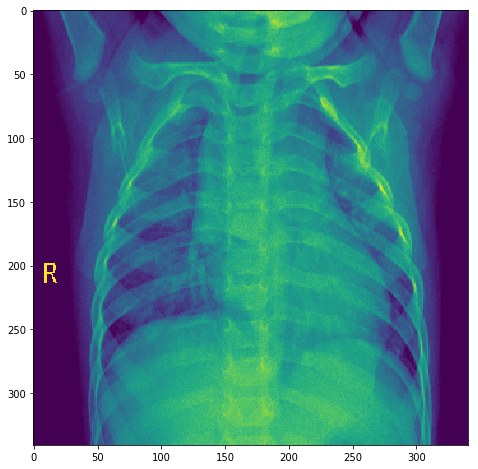

Normal


6

In [2]:
trainDataDir = "datasets/chest_xray_mod/Training"
validationDataDir = "datasets/chest_xray_mod/Validation"
testDataDir = "datasets/chest_xray_mod/Testing"
batchSize = 16
width = 341
height = width
trainDataGen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=9,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
)
validationDataGen = ImageDataGenerator(
    rescale=1./255
)
testDataGen = ImageDataGenerator(
    rescale=1./255
)
trainGenerator = trainDataGen.flow_from_directory(
    trainDataDir,
    target_size=(width, height),
    batch_size=batchSize,
    class_mode="binary",
    color_mode="grayscale"
)
validationGenerator = validationDataGen.flow_from_directory(
    validationDataDir,
    target_size=(width, height),
    batch_size=batchSize,
    class_mode="binary",
    color_mode="grayscale",
    shuffle=False
)
testGenerator = testDataGen.flow_from_directory(
    testDataDir,
    target_size=(width, height),
    batch_size=batchSize,
    class_mode="binary",
    color_mode="grayscale",
    shuffle=False
)
for X_valid, Y_valid in validationGenerator:
    break
idx = np.random.choice(batchSize)
plt.figure(figsize=(8, 8))
plt.imshow(X_valid[idx, :, :, 0])
plt.show()
if Y_valid[idx]==0:
    print("Normal")
else:
    print("Pneumonia")
idx

## Building and Training the Model
The model below is the result of several training iterations. The approach is to first find a model that achieves high performance on the training set. Due to overfitting, such model will usually perform significantly worse on the validation set **[8]**. Restricting the model, e.g., by reducing the number of trainable parameters, via regularization, or by introducing dropout, will reduce overfitting. The art is to keep the performance metrics (accuracy or loss function) for the training and validation set close to each other even after many, many epochs.

Here, we choose convolutional layers followed by dense layers. He initialization is preferred for layers with ReLU activation and Xavier (Glorot) initialization for the output layer with sigmoid activation **[9]**. The input shape, filter size, and strides are all chosen such that all the convolutions fit exactly. This is efficient but it is not a necessity. We also apply L2-regularization and dropout to the dense layers (but obviously no dropout to the final output layer). This model does not have a vast number of parameters and performs reasonably well but there is certainly still room for optimization. For details, see

**[8]** https://en.wikipedia.org/wiki/Overfitting (wikipedia page on overfitting) and<br>
**[9]** https://stackoverflow.com/questions/48641192/xavier-and-he-normal-initialization-difference (stack overflow discussion on Xavier and He initialization methods).

In [3]:
drop_rate = 0.5
l2_reg = regularizers.l2(0.03)
model = Sequential()
model.add(Conv2D(75, (3,3), kernel_initializer="he_uniform", strides=2,
                 activation="relu", input_shape=(width, height, 1)))
model.add(MaxPooling2D())
model.add(Conv2D(75, (3,3), kernel_initializer="he_uniform", strides=2, activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(75, (3,3), kernel_initializer="he_uniform", strides=2, activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(75, (3,3), kernel_initializer="he_uniform", strides=2, activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dropout(drop_rate))
model.add(Dense(75, kernel_initializer="he_uniform",
                kernel_regularizer=l2_reg, activation="relu"))
model.add(Dropout(drop_rate))
model.add(Dense(75, kernel_initializer="he_uniform",
                kernel_regularizer=l2_reg, activation="relu"))
model.add(Dense(1, kernel_initializer="glorot_uniform",
                kernel_regularizer=l2_reg, activation="sigmoid"))
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 170, 170, 75)      750       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 75)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 75)        50700     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 75)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 75)        50700     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 75)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 75)          50700     
__________

During training, we save the model that performs best on the validation set and overwrite that checkpoint every time the performance metric on the validation set improves. The loss function is chosen over the accuracy as the performance metric since it is continuous while the accuracy is discrete due to the finite number of instances. In particular with the few instances in the validation set the loss function gives a more fine grained picture of the performance.

We stop training early **[10, 11]** if the validation loss does not improve for a certain number of epochs and also reduce the learning rate if the loss on the training set does not improve by a certain amount for a different number of epochs. After training, we load the best saved model checkpoint **[11, 12]** and evaluate it once more on a batch of the validation set. For details, see

**[10]** https://en.wikipedia.org/wiki/Early_stopping (wikipedia page on early stopping),<br>
**[11]** https://keras.io/callbacks (on Keras callbacks), and<br>
**[12]** https://keras.io/getting-started/faq/#savingloading-whole-models-architecture-weights-optimizer-state (on saving and loading Keras models).

In [4]:
saved_model_path = "./best_model_files/my_model.h5"
stepsTraining = trainGenerator.samples // batchSize
stepsValidation = validationGenerator.samples // batchSize
reduceLROP = ReduceLROnPlateau(
    monitor="loss",
    factor=1/2,
    patience=80,  # keep this in balance with epochs and patience of earlyStopping
    verbose=1,
    mode="auto",
    min_delta=0.01,
    cooldown=0,
    min_lr=0
)
earlyStopping = EarlyStopping(
    monitor="val_loss",
    mode="auto", 
    baseline=None,
    patience=200, # keep this in balance with epochs and patience of reduceLROP
    verbose=1
)
modelCheckpoint = ModelCheckpoint(
    saved_model_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    period=1
)
history = model.fit_generator(
    generator = trainGenerator,
    steps_per_epoch = stepsTraining,
    epochs=500,   # keep this in balance with patience of reduceLROP and of earlyStopping
    validation_data = validationGenerator,
    validation_steps = stepsValidation,
    callbacks=[reduceLROP, earlyStopping, modelCheckpoint]
)
model = load_model(saved_model_path)
for X_valid, Y_valid in validationGenerator:
    break
model.evaluate(x=X_valid, y=Y_valid)

Epoch 1/500
316/317 [============================>.] - ETA: 0s - loss: 3.7286 - acc: 0.7397
Epoch 00001: val_loss improved from inf to 1.19223, saving model to ./best_model_files/my_model.h5
317/317 [==============================] - 56s 176ms/step - loss: 3.7199 - acc: 0.7399 - val_loss: 1.1922 - val_acc: 0.5000
Epoch 2/500
316/317 [============================>.] - ETA: 0s - loss: 0.5989 - acc: 0.8020
Epoch 00002: val_loss improved from 1.19223 to 0.61195, saving model to ./best_model_files/my_model.h5
317/317 [==============================] - 54s 171ms/step - loss: 0.5986 - acc: 0.8019 - val_loss: 0.6119 - val_acc: 0.7500
Epoch 3/500
316/317 [============================>.] - ETA: 0s - loss: 0.4184 - acc: 0.8301
Epoch 00003: val_loss did not improve from 0.61195
317/317 [==============================] - 54s 171ms/step - loss: 0.4184 - acc: 0.8299 - val_loss: 0.6320 - val_acc: 0.6375
Epoch 4/500
316/317 [============================>.] - ETA: 0s - loss: 0.3880 - acc: 0.8430
Epoch 0

Epoch 30/500
316/317 [============================>.] - ETA: 0s - loss: 0.2043 - acc: 0.9369
Epoch 00030: val_loss improved from 0.29030 to 0.28879, saving model to ./best_model_files/my_model.h5
317/317 [==============================] - 53s 168ms/step - loss: 0.2040 - acc: 0.9371 - val_loss: 0.2888 - val_acc: 0.8875
Epoch 31/500
316/317 [============================>.] - ETA: 0s - loss: 0.1822 - acc: 0.9474
Epoch 00031: val_loss did not improve from 0.28879
317/317 [==============================] - 53s 167ms/step - loss: 0.1820 - acc: 0.9476 - val_loss: 0.3013 - val_acc: 0.9125
Epoch 32/500
316/317 [============================>.] - ETA: 0s - loss: 0.1963 - acc: 0.9426
Epoch 00032: val_loss improved from 0.28879 to 0.28122, saving model to ./best_model_files/my_model.h5
317/317 [==============================] - 53s 168ms/step - loss: 0.1961 - acc: 0.9428 - val_loss: 0.2812 - val_acc: 0.9062
Epoch 33/500
316/317 [============================>.] - ETA: 0s - loss: 0.1940 - acc: 0.9436

Epoch 59/500
316/317 [============================>.] - ETA: 0s - loss: 0.1426 - acc: 0.9604
Epoch 00059: val_loss did not improve from 0.18676
317/317 [==============================] - 53s 167ms/step - loss: 0.1423 - acc: 0.9606 - val_loss: 0.2447 - val_acc: 0.9187
Epoch 60/500
316/317 [============================>.] - ETA: 0s - loss: 0.1401 - acc: 0.9604
Epoch 00060: val_loss did not improve from 0.18676
317/317 [==============================] - 53s 167ms/step - loss: 0.1398 - acc: 0.9606 - val_loss: 0.2045 - val_acc: 0.9250
Epoch 61/500
316/317 [============================>.] - ETA: 0s - loss: 0.1508 - acc: 0.9551
Epoch 00061: val_loss did not improve from 0.18676
317/317 [==============================] - 53s 168ms/step - loss: 0.1510 - acc: 0.9550 - val_loss: 0.1927 - val_acc: 0.9375
Epoch 62/500
316/317 [============================>.] - ETA: 0s - loss: 0.1454 - acc: 0.9598
Epoch 00062: val_loss improved from 0.18676 to 0.18536, saving model to ./best_model_files/my_model.h5


Epoch 89/500
316/317 [============================>.] - ETA: 0s - loss: 0.1172 - acc: 0.9668
Epoch 00089: val_loss did not improve from 0.16196
317/317 [==============================] - 53s 168ms/step - loss: 0.1173 - acc: 0.9665 - val_loss: 0.2086 - val_acc: 0.9437
Epoch 90/500
316/317 [============================>.] - ETA: 0s - loss: 0.1245 - acc: 0.9674
Epoch 00090: val_loss did not improve from 0.16196
317/317 [==============================] - 53s 167ms/step - loss: 0.1251 - acc: 0.9673 - val_loss: 0.1866 - val_acc: 0.9437
Epoch 91/500
316/317 [============================>.] - ETA: 0s - loss: 0.1253 - acc: 0.9664
Epoch 00091: val_loss did not improve from 0.16196
317/317 [==============================] - 53s 167ms/step - loss: 0.1256 - acc: 0.9663 - val_loss: 0.1706 - val_acc: 0.9563
Epoch 92/500
316/317 [============================>.] - ETA: 0s - loss: 0.1231 - acc: 0.9689
Epoch 00092: val_loss did not improve from 0.16196
317/317 [==============================] - 53s 168ms

Epoch 149/500
316/317 [============================>.] - ETA: 0s - loss: 0.0983 - acc: 0.9741
Epoch 00149: val_loss did not improve from 0.12712
317/317 [==============================] - 53s 168ms/step - loss: 0.0982 - acc: 0.9742 - val_loss: 0.1658 - val_acc: 0.9563
Epoch 150/500
316/317 [============================>.] - ETA: 0s - loss: 0.1013 - acc: 0.9727
Epoch 00150: val_loss did not improve from 0.12712
317/317 [==============================] - 53s 167ms/step - loss: 0.1012 - acc: 0.9728 - val_loss: 0.2525 - val_acc: 0.9437
Epoch 151/500
316/317 [============================>.] - ETA: 0s - loss: 0.1033 - acc: 0.9727
Epoch 00151: val_loss did not improve from 0.12712
317/317 [==============================] - 53s 167ms/step - loss: 0.1031 - acc: 0.9728 - val_loss: 0.2471 - val_acc: 0.9375
Epoch 152/500
316/317 [============================>.] - ETA: 0s - loss: 0.0950 - acc: 0.9751
Epoch 00152: val_loss did not improve from 0.12712
317/317 [==============================] - 53s 1

316/317 [============================>.] - ETA: 0s - loss: 0.0899 - acc: 0.9773
Epoch 00209: val_loss did not improve from 0.11262
317/317 [==============================] - 54s 171ms/step - loss: 0.0902 - acc: 0.9771 - val_loss: 0.1934 - val_acc: 0.9187
Epoch 210/500
316/317 [============================>.] - ETA: 0s - loss: 0.0845 - acc: 0.9777
Epoch 00210: val_loss did not improve from 0.11262
317/317 [==============================] - 54s 171ms/step - loss: 0.0843 - acc: 0.9777 - val_loss: 0.1755 - val_acc: 0.9563
Epoch 211/500
316/317 [============================>.] - ETA: 0s - loss: 0.0993 - acc: 0.9725
Epoch 00211: val_loss improved from 0.11262 to 0.10895, saving model to ./best_model_files/my_model.h5
317/317 [==============================] - 54s 171ms/step - loss: 0.0992 - acc: 0.9726 - val_loss: 0.1089 - val_acc: 0.9688
Epoch 212/500
316/317 [============================>.] - ETA: 0s - loss: 0.0924 - acc: 0.9767
Epoch 00212: val_loss did not improve from 0.10895
317/317 [=

316/317 [============================>.] - ETA: 0s - loss: 0.0859 - acc: 0.9790
Epoch 00269: val_loss did not improve from 0.09422
317/317 [==============================] - 54s 171ms/step - loss: 0.0858 - acc: 0.9791 - val_loss: 0.1855 - val_acc: 0.9688
Epoch 270/500
316/317 [============================>.] - ETA: 0s - loss: 0.0922 - acc: 0.9790
Epoch 00270: val_loss did not improve from 0.09422
317/317 [==============================] - 54s 170ms/step - loss: 0.0925 - acc: 0.9789 - val_loss: 0.1196 - val_acc: 0.9563
Epoch 271/500
316/317 [============================>.] - ETA: 0s - loss: 0.0868 - acc: 0.9767
Epoch 00271: val_loss did not improve from 0.09422
317/317 [==============================] - 54s 171ms/step - loss: 0.0867 - acc: 0.9767 - val_loss: 0.1820 - val_acc: 0.9437
Epoch 272/500
316/317 [============================>.] - ETA: 0s - loss: 0.0742 - acc: 0.9820
Epoch 00272: val_loss did not improve from 0.09422
317/317 [==============================] - 54s 171ms/step - lo

Epoch 300/500
316/317 [============================>.] - ETA: 0s - loss: 0.0881 - acc: 0.9773
Epoch 00300: val_loss did not improve from 0.09422
317/317 [==============================] - 54s 169ms/step - loss: 0.0879 - acc: 0.9773 - val_loss: 0.1291 - val_acc: 0.9625
Epoch 301/500
316/317 [============================>.] - ETA: 0s - loss: 0.0790 - acc: 0.9802
Epoch 00301: val_loss did not improve from 0.09422
317/317 [==============================] - 54s 169ms/step - loss: 0.0791 - acc: 0.9803 - val_loss: 0.1887 - val_acc: 0.9437
Epoch 302/500
316/317 [============================>.] - ETA: 0s - loss: 0.0697 - acc: 0.9824
Epoch 00302: val_loss did not improve from 0.09422
317/317 [==============================] - 54s 169ms/step - loss: 0.0697 - acc: 0.9825 - val_loss: 0.1227 - val_acc: 0.9688
Epoch 303/500
316/317 [============================>.] - ETA: 0s - loss: 0.0891 - acc: 0.9782
Epoch 00303: val_loss did not improve from 0.09422
317/317 [==============================] - 54s 1

316/317 [============================>.] - ETA: 0s - loss: 0.0786 - acc: 0.9800
Epoch 00330: val_loss did not improve from 0.08878
317/317 [==============================] - 53s 168ms/step - loss: 0.0786 - acc: 0.9801 - val_loss: 0.1828 - val_acc: 0.9563
Epoch 331/500
316/317 [============================>.] - ETA: 0s - loss: 0.0728 - acc: 0.9816
Epoch 00331: val_loss did not improve from 0.08878
317/317 [==============================] - 53s 167ms/step - loss: 0.0726 - acc: 0.9817 - val_loss: 0.1666 - val_acc: 0.9563
Epoch 332/500
316/317 [============================>.] - ETA: 0s - loss: 0.0771 - acc: 0.9806
Epoch 00332: val_loss did not improve from 0.08878
317/317 [==============================] - 53s 167ms/step - loss: 0.0770 - acc: 0.9807 - val_loss: 0.1250 - val_acc: 0.9688
Epoch 333/500
316/317 [============================>.] - ETA: 0s - loss: 0.0812 - acc: 0.9777
Epoch 00333: val_loss did not improve from 0.08878
317/317 [==============================] - 53s 168ms/step - lo

316/317 [============================>.] - ETA: 0s - loss: 0.0521 - acc: 0.986 - ETA: 0s - loss: 0.0521 - acc: 0.9869
Epoch 00360: val_loss did not improve from 0.08470
317/317 [==============================] - 53s 169ms/step - loss: 0.0520 - acc: 0.9870 - val_loss: 0.1192 - val_acc: 0.9688
Epoch 361/500
316/317 [============================>.] - ETA: 0s - loss: 0.0576 - acc: 0.9854
Epoch 00361: val_loss did not improve from 0.08470
317/317 [==============================] - 54s 169ms/step - loss: 0.0575 - acc: 0.9854 - val_loss: 0.1071 - val_acc: 0.9688
Epoch 362/500
316/317 [============================>.] - ETA: 0s - loss: 0.0559 - acc: 0.9834
Epoch 00362: val_loss did not improve from 0.08470
317/317 [==============================] - 53s 169ms/step - loss: 0.0566 - acc: 0.9832 - val_loss: 0.0999 - val_acc: 0.9750
Epoch 363/500
316/317 [============================>.] - ETA: 0s - loss: 0.0611 - acc: 0.9840
Epoch 00363: val_loss did not improve from 0.08470
317/317 [===============

Epoch 421/500
316/317 [============================>.] - ETA: 0s - loss: 0.0534 - acc: 0.9883
Epoch 00421: val_loss did not improve from 0.06861
317/317 [==============================] - 54s 171ms/step - loss: 0.0534 - acc: 0.9884 - val_loss: 0.0871 - val_acc: 0.9688
Epoch 422/500
316/317 [============================>.] - ETA: 0s - loss: 0.0553 - acc: 0.9856
Epoch 00422: val_loss did not improve from 0.06861
317/317 [==============================] - 54s 169ms/step - loss: 0.0552 - acc: 0.9856 - val_loss: 0.1011 - val_acc: 0.9812
Epoch 423/500
316/317 [============================>.] - ETA: 0s - loss: 0.0590 - acc: 0.9854
Epoch 00423: val_loss did not improve from 0.06861
317/317 [==============================] - 54s 169ms/step - loss: 0.0591 - acc: 0.9854 - val_loss: 0.0863 - val_acc: 0.9875
Epoch 424/500
316/317 [============================>.] - ETA: 0s - loss: 0.0470 - acc: 0.9887
Epoch 00424: val_loss did not improve from 0.06861
317/317 [==============================] - 53s 1

Epoch 482/500
316/317 [============================>.] - ETA: 0s - loss: 0.0411 - acc: 0.9899
Epoch 00482: val_loss did not improve from 0.06861
317/317 [==============================] - 53s 169ms/step - loss: 0.0413 - acc: 0.9897 - val_loss: 0.0948 - val_acc: 0.9875
Epoch 483/500
316/317 [============================>.] - ETA: 0s - loss: 0.0486 - acc: 0.9875
Epoch 00483: val_loss did not improve from 0.06861
317/317 [==============================] - 54s 169ms/step - loss: 0.0485 - acc: 0.9876 - val_loss: 0.0861 - val_acc: 0.9875
Epoch 484/500
316/317 [============================>.] - ETA: 0s - loss: 0.0421 - acc: 0.9893
Epoch 00484: val_loss did not improve from 0.06861
317/317 [==============================] - 54s 169ms/step - loss: 0.0421 - acc: 0.9894 - val_loss: 0.0962 - val_acc: 0.9812
Epoch 485/500
316/317 [============================>.] - ETA: 0s - loss: 0.0468 - acc: 0.9885
Epoch 00485: val_loss did not improve from 0.06861
317/317 [==============================] - 54s 1

[0.01707109622657299, 1.0]

## Training History and Model Performance
Once training has finished, we look at the evolution of performance metrics during training and then evaluate the final model on the test set.

The plots below show that the accuracy (the higher the better) of the model is higher on the training set than on the validation set. The accuarcy on the validation set shows also stronger fluctuations but generally follows the trend of the training set. Importantly, the accuracy on the validation set does not deteriorate after a certain number of epochs. This would be a sign of overfitting (see Ref. **[8]** above).  The loss function (the lower the better) behaves correspondingly.

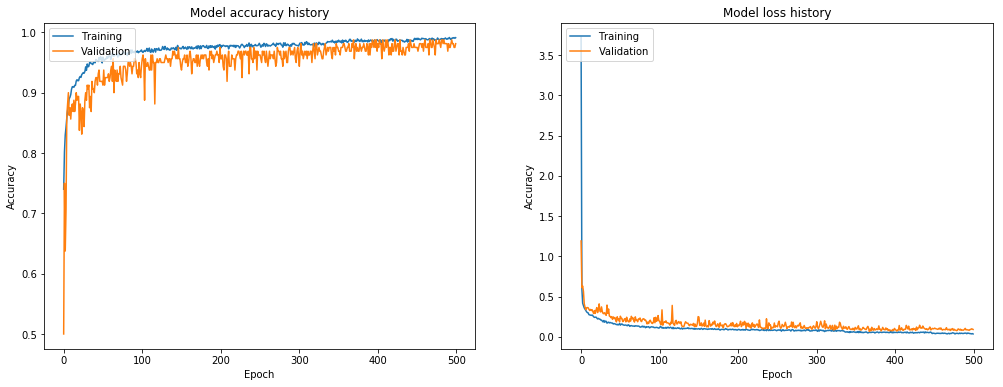

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(17, 6))
# subplot 1
ax[0].plot(history.history["acc"], "C0")
ax[0].plot(history.history["val_acc"], "C1")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Model accuracy history")
ax[0].axis("tight")
ax[0].legend(["Training", "Validation"], loc="upper left")
# subplot 2
ax[1].plot(history.history["loss"], "C0")
ax[1].plot(history.history["val_loss"], "C1")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Model loss history")
ax[1].axis("tight")
ax[1].legend(["Training", "Validation"], loc="upper left")
# show all subplots
plt.show()

The next cell generates and plots a *Confusion Matrix* **[13, 14]** to illustrate how well the model distinguishes (or confuses) the different classes. The following table shows what the numbers in the confusion matrix mean.

<table>
    <tr>
        <td></td>
        <td><b>Classified as Normal</b></td>
        <td><b>Classified as Pneumonia</b></td>
    </tr>
    <tr>
        <td><b>Actual Normal (0)</b></td>
        <td>classification (0) correct</td>
        <td>classification (1) incorrect</td>
    </tr>
    <tr>
        <td><b>Actual Pneumonia (1)</b></td>
        <td>classification (0) incorrect</td>
        <td>classification (1) correct</td>
    </tr>
</table>

For details, see

**[13]** https://en.wikipedia.org/wiki/Confusion_matrix (wikipedia page on the confusion matrix) and<br>
**[14]** https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html (documentation page for the `confusion_matrix` command of Scikit-Learn).

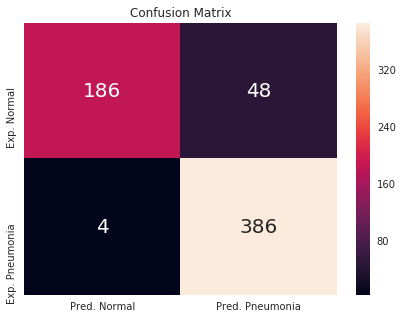

In [6]:
labels = testGenerator.classes
stepsTesting = testGenerator.samples // batchSize
predictions = model.predict_generator(testGenerator, stepsTesting)
valResults = np.around(predictions)
confMatrixdf = pd.DataFrame(
    confusion_matrix(labels, valResults),
    index=["Exp. Normal", "Exp. Pneumonia"],
    columns=["Pred. Normal", "Pred. Pneumonia"]
)
plt.figure(figsize=(7, 5))
sns.set()
plt.title("Confusion Matrix")
sns.heatmap(confMatrixdf, annot=True, annot_kws={"size": "20"}, fmt="d")
plt.show()

The *Receiver Operating Characteristic curve* (**ROC curve**) plots the *True Positive Rate* (**TPR**) vs. the *False Positive Rate* (**FPR**) **[15, 16]**. The TPR is also referred to as *recall* and is the ratio of actual true (1) instances that have been classified as true over all actual true instances. Likewise, the FPR is the ratio of actual false instances that have been classified as true over all false instances.

If the model performs well, actual true (1) instances should all have logits close to 1 and actual false (0) instances should all have logits close to 0. A logit is classified as 1 (0) if it is greater (smaller) than a **threshold**. So the threshold must lie between 0 and 1. If it is 1 (this is the left end of the ROC curve) then both TPR and FPR are zero. If it is 0 (this is the right end of the ROC curve) then both TPR and FPR are 1. As the threshold is decreased to values slightly smaller than 1, the TPR should increse much faster than the FPR. There are two special cases:
1. The algorithm can perfectly separate the two actual classes such that all true instances  have logit values higher than all false instances. In this case, the threshold can be chosen above all logits of false instances and below all logits of true instances such that the FPR is zero while the TPR is 1. Then the ROC curve has a constant value of 1.
2. The algorithm is absolutely incapable of distinguishing the two actual classes (random logits). Independent of the threshold value, the percentage of actual true instances above the threshold is expected to be the same as the percentage of false instances above the threshold. So as the threshold is lowered from 1, the TPR is expected to increase in tandem with the FPR. Then the ROC curve is expected to be a diagonal: TPR=FPR.

Below, we show the ROC curve and the output of Scikit-Learn's classification report **[17, 18]**. For details, see

**[15]** https://en.wikipedia.org/wiki/Receiver_operating_characteristic (wikipedia page on the receiver operating characteristic curve),<br>
**[16]** https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html (documentation page for the `roc_curve` command of Scikit-Learn)<br>
**[17]** https://en.wikipedia.org/wiki/F1_score (wikipedia page on the F1 score and other metrics), and<br>
**[18]** https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html (documentation page for the `classification_report` command of Scikit-Learn).

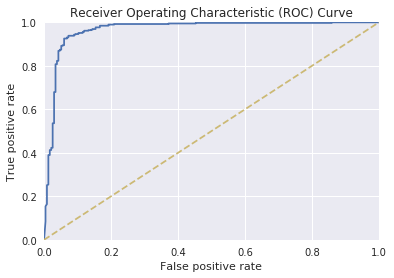


		CLASSIFICATION REPORT

              precision    recall  f1-score   support

      Normal       0.98      0.79      0.88       234
   Pneumonia       0.89      0.99      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.89      0.91       624
weighted avg       0.92      0.92      0.91       624



In [7]:
fpr, tpr, thresholds = roc_curve(labels, predictions)
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(fpr, tpr, "C0")
plt.plot([0, 1], [0, 1], "C4--")
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.show()
print("\n\t\tCLASSIFICATION REPORT\n")
print(classification_report(labels, valResults, target_names = ["Normal", "Pneumonia"]))

Finish.